In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [6]:
gamma = 5.0/3.0
B0 = 1.0
rho0 = 1.0
sheat_thickness = 1.0
p0 = B0**2 / 2.0 #カレントシート中央での圧力
beta_upstream = 0.2
VA = B0 / np.sqrt(rho0)
x_max = 400.0
y_max = 20.0
dx = sheat_thickness / 32.0
dy = sheat_thickness / 32.0
nx = int(x_max / dx)
ny = int(2.0 * y_max / dy)
dt = 0.0
CFL = 0.4
x = np.arange(0.0, x_max, dx)
y = np.arange(-y_max, y_max, dy)
X, Y = np.meshgrid(x, y)

eta = 1.0 / 500.0
S = 0.5 * x_max * VA / eta
print(f"Lundquist number = {S:.1f}")
print(f"box size {nx} X {ny}")

Lundquist number = 100000.0
box size 12800 X 1280


(-1.9999999999, 1.9999999999)

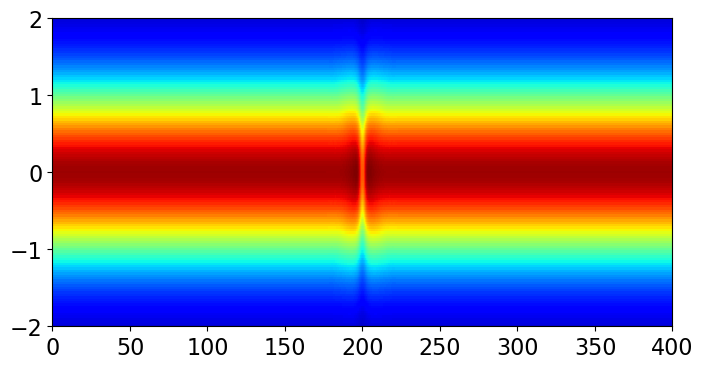

In [4]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(111)

dirname = "."
#log = np.loadtxt(f"{dirname}/log_plasmoid.txt", delimiter=',')
step = 38000
filename = f"{dirname}/plasmoid_{step}.bin"
with open(filename, 'rb') as f:
    U = np.fromfile(f, dtype=np.float64)
U = U.reshape(nx, ny, 8).T

rho = U[0, :, :]
u = U[1, :, :] / rho 
v = U[2, :, :] / rho 
w = U[3, :, :] / rho 
Bx = U[4, :, :]
By = U[5, :, :]
Bz = U[6, :, :]
e = U[7, :, :]
p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
magnetic_pressure = 1/2 * (Bx**2+By**2+Bz**2)
pT = p + magnetic_pressure

contour = ax1.pcolormesh(X, Y, rho, cmap='jet')
if step == 0:
    cbar = plt.colorbar(contour, ax=ax1)
    cbar.set_label(r"$\rho$", fontsize=24, rotation=0, labelpad=10)
quiver_interval = 20
#ax1.quiver(X[::quiver_interval, ::quiver_interval], Y[::quiver_interval, ::quiver_interval], 
#        u[::quiver_interval, ::quiver_interval], v[::quiver_interval, ::quiver_interval],
#        scale=2.0, color='white')

#ax1.text(0.8, 1.02, f"t = {log[int(step/100)][1]:.3f}", transform=ax1.transAxes, fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_xlim(+1e-10, x_max-1e-10)
ax1.set_ylim(-y_max+1e-10, y_max-1e-10)

(-19.9999999999, 19.9999999999)

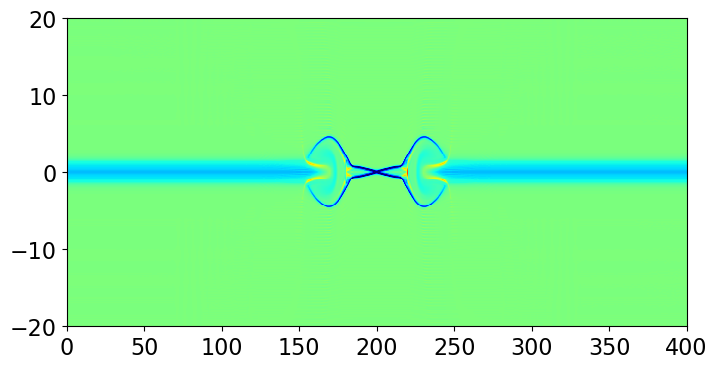

In [23]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(111)

dirname = "results"
#log = np.loadtxt(f"{dirname}/log_plasmoid.txt", delimiter=',')
step = 4000
filename = f"{dirname}/plasmoid_{step}.bin"
with open(filename, 'rb') as f:
    U = np.fromfile(f, dtype=np.float64)
U = U.reshape(nx, ny, 8).T

Bx = U[4, :, :]
By = U[5, :, :]
Bx = 0.5 * (Bx + np.roll(Bx, 1, axis=1))
By = 0.5 * (By + np.roll(By, 1, axis=0))
currentZ = (By - np.roll(By, 1, axis=1)) / dx - (Bx - np.roll(Bx, 1, axis=0)) / dy 

contour = ax1.pcolormesh(X, Y, currentZ, vmin=-2.0, vmax=2.0, cmap='jet')
if step == 0:
    cbar = plt.colorbar(contour, ax=ax1)
    cbar.set_label(r"$j_z$", fontsize=24, rotation=0, labelpad=10)
quiver_interval = 20
#ax1.quiver(X[::quiver_interval, ::quiver_interval], Y[::quiver_interval, ::quiver_interval], 
#        u[::quiver_interval, ::quiver_interval], v[::quiver_interval, ::quiver_interval],
#        scale=2.0, color='white')

#ax1.text(0.8, 1.02, f"t = {log[int(step/100)][1]:.3f}", transform=ax1.transAxes, fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_xlim(+1e-10, x_max-1e-10)
ax1.set_ylim(-y_max+1e-10, y_max-1e-10)

(-19.9999999999, 19.9999999999)

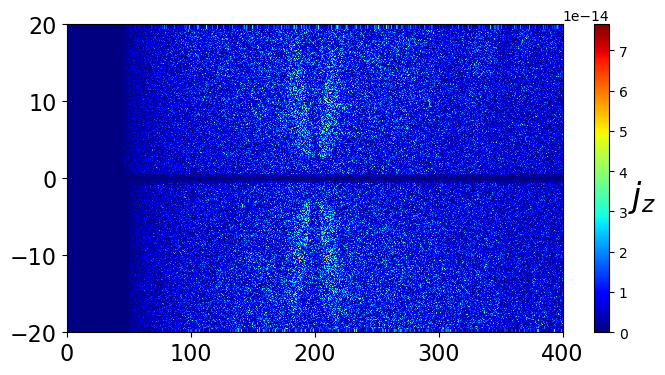

In [10]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(111)

dirname = "results"
#log = np.loadtxt(f"{dirname}/log_plasmoid.txt", delimiter=',')
step = 1000
filename = f"{dirname}/plasmoid_{step}.bin"
with open(filename, 'rb') as f:
    U = np.fromfile(f, dtype=np.float64)
U = U.reshape(nx, ny, 8).T

Bx = U[4, :, :]
By = U[5, :, :]
noise = (Bx - np.roll(Bx, 1, axis=1)) / dx + (By - np.roll(By, 1, axis=0)) / dy
noise[:, [0, -1]] = noise[:, [1, -2]]
noise[[0, -1], :] = noise[[1, -2], :]

contour = ax1.pcolormesh(X, Y, np.abs(noise), cmap='jet')
cbar = plt.colorbar(contour, ax=ax1)
cbar.set_label(r"$j_z$", fontsize=24, rotation=0, labelpad=10)
quiver_interval = 20
#ax1.quiver(X[::quiver_interval, ::quiver_interval], Y[::quiver_interval, ::quiver_interval], 
#        u[::quiver_interval, ::quiver_interval], v[::quiver_interval, ::quiver_interval],
#        scale=2.0, color='white')

#ax1.text(0.8, 1.02, f"t = {log[int(step/100)][1]:.3f}", transform=ax1.transAxes, fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_xlim(+1e-10, x_max-1e-10)
ax1.set_ylim(-y_max+1e-10, y_max-1e-10)

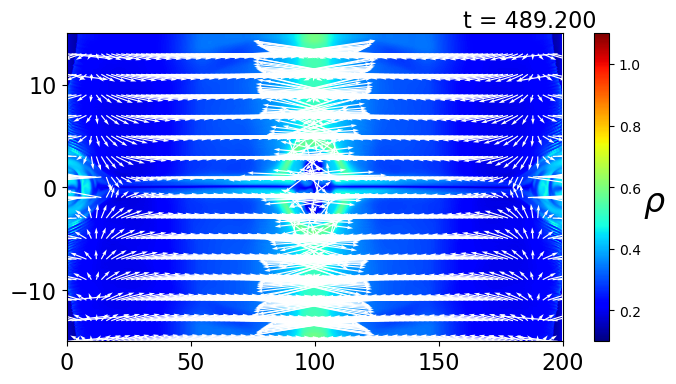

In [137]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(111)

dirname = "results"
log = np.loadtxt(f"{dirname}/log_plasmoid.txt", delimiter=',')
total_steps = int(log[-1][0])
interval = 100
for step in range(0, total_steps+interval, interval):
    ax1.clear()

    filename = f"{dirname}/plasmoid_{step}.bin"
    with open(filename, 'rb') as f:
        U = np.fromfile(f, dtype=np.float64)
    U = U.reshape(nx, ny, 8).T

    rho = U[0, :, :]
    u = U[1, :, :] / rho 
    v = U[2, :, :] / rho 
    w = U[3, :, :] / rho 
    Bx = U[4, :, :]
    By = U[5, :, :]
    Bz = U[6, :, :]
    e = U[7, :, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
    magnetic_pressure = 1/2 * (Bx**2+By**2+Bz**2)
    pT = p + magnetic_pressure

    contour = ax1.pcolormesh(X, Y, rho, vmin=0.1, vmax=1.1, cmap='jet')
    if step == 0:
        cbar = plt.colorbar(contour, ax=ax1)
        cbar.set_label(r"$\rho$", fontsize=24, rotation=0, labelpad=10)
    quiver_interval = 20
    ax1.quiver(X[::quiver_interval, ::quiver_interval], Y[::quiver_interval, ::quiver_interval], 
            u[::quiver_interval, ::quiver_interval], v[::quiver_interval, ::quiver_interval],
            scale=2.0, color='white')

    ax1.text(0.8, 1.02, f"t = {log[int(step/100)][1]:.3f}", transform=ax1.transAxes, fontsize=16)
    ax1.tick_params(labelsize=16)
    ax1.set_xlim(0.0, x_max+1e-10)
    ax1.set_ylim(-y_max, y_max+1e-10)

    fig.savefig(f"pictures/{step}.png", dpi=200)


filename = "plasmoid_rho1.mp4"
img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 10.0
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename, fourcc=fourcc, fps=fps, frameSize=framesize)

for step in range(0, total_steps+interval, interval):
    img = cv2.imread(f'./pictures/{step}.png')
    video.write(img)
video.release()